In [1]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer,TorchNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data.examples import get_stallion_data


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\ProgramData\Anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
df = pd.read_csv("../bitcoin_daily.csv")
df.converted_ts = pd.to_datetime(df.converted_ts)


In [3]:
#create time_idx
df['time_idx'] = (df["converted_ts"] - df["converted_ts"].min()).dt.days

#add features
df["month"] = df.converted_ts.dt.month.astype(str).astype("category") 
df.dropna(inplace = True)
df.info()

#NEEDED FOR TIMESERIES DATASET
df['constant'] = 'bitcoin'
df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3375 entries, 0 to 3377
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   converted_ts       3375 non-null   datetime64[ns]
 1   Timestamp          3375 non-null   float64       
 2   Open               3375 non-null   float64       
 3   High               3375 non-null   float64       
 4   Low                3375 non-null   float64       
 5   Close              3375 non-null   float64       
 6   Volume_(BTC)       3375 non-null   float64       
 7   Volume_(Currency)  3375 non-null   float64       
 8   Weighted_Price     3375 non-null   float64       
 9   time_idx           3375 non-null   int64         
 10  month              3375 non-null   category      
dtypes: category(1), datetime64[ns](1), float64(8), int64(1)
memory usage: 293.7 KB


,converted_ts,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,time_idx,month,constant
0,2011-12-31,1.325351e+09,4.488000,4.502000,4.488000,4.502000,19.363976,86.439900,4.493282,0,12,bitcoin
1,2012-01-01,1.325445e+09,4.920000,4.920000,4.920000,4.920000,10.050000,49.450000,4.920000,1,1,bitcoin
2,2012-01-02,1.325535e+09,5.000000,5.000000,5.000000,5.000000,19.048000,95.240000,5.000000,2,1,bitcoin
3,2012-01-03,1.325610e+09,5.216667,5.216667,5.216667,5.216667,10.039698,52.915868,5.216667,3,1,bitcoin
4,2012-01-04,1.325695e+09,5.334000,5.355000,5.334000,5.355000,11.511326,61.513860,5.341343,4,1,bitcoin
...,...,...,...,...,...,...,...,...,...,...,...,...
3373,2021-03-26,1.616774e+09,53713.961911,53744.860820,53685.498756,53715.866678,3.335749,178897.580671,53714.112556,3373,3,bitcoin
3374,2021-03-27,1.616861e+09,55368.343291,55394.514668,55343.783361,55370.368281,1.762685,97724.174269,55368.274704,3374,3,bitcoin
3375,2021-03-28,1.616947e+09,55743.054500,55766.689734,55720.313625,55744.439153,1.387384,77112.419739,55742.179404,3375,3,bitcoin
3376,2021-03-29,1.617034e+09,57235.672481,57267.246852,57205.425351,57236.598603,3.868826,221942.790902,57234.152701,3376,3,bitcoin


In [4]:
prediction_length = 7
max_encoder_length = 30
training_cutoff = df["time_idx"].max() - prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx= "time_idx",
    target= "Close",
    group_ids = ['constant'],
    min_encoder_length=max_encoder_length//2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["month"],  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "Open",
        "High",
        "Low",
        "Volume_(BTC)",
        "Volume_(Currency)",
        "Weighted_Price",
        "Close"
    ],
    target_normalizer=TorchNormalizer(transformation="softplus"),  # use softplus and normalize
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps = True
)




In [5]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10)



In [6]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


1717.4140625

In [7]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=128,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=SMAPE(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
    optimizer='adam'
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=0)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=0)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


Number of parameters in network: 867.7k


In [8]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=500,
    gpus=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    #limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10, 
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 2750.3k


In [9]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 72    
3  | prescalers                         | ModuleDict                      | 3.8 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 312 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 950 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 209 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (26)

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)

#average p50 loss overall
print((actuals - predictions).abs().mean().item())
#average p50 loss per time series
print((actuals - predictions).abs().mean(axis=1))

In [13]:
##run for HYPERPARAMETER TUNING, TAKES VERY LONG TIME

# import pickle

# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# # create study
# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path="optuna_test",
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 128),
#     hidden_continuous_size_range=(8, 128),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save study results - also we can resume tuning at a later point in time
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial.params)

[I 2023-03-15 19:35:11,329] A new study created in memory with name: no-name-135e6292-5044-4e12-849b-cc91111454c3
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\uti

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:613: UserWarning: Checkpoint directory C:\Users\Tuan Nguyen\CSC413_Project\TimeSeriesTransformer\optuna_test\trial_8

[I 2023-03-15 19:55:24,646] Trial 10 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attr

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does no

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epo

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epo

[I 2023-03-15 20:04:40,696] Trial 35 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore

[I 2023-03-15 20:07:05,563] Trial 38 pruned. Trial was pruned at epoch 16.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Att

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does no

HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value 

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
[I 2023-03-15 20:19:23,492] Trial 57 pruned. Trial was pruned at epoch 4.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator

[I 2023-03-15 20:20:05,182] Trial 60 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-03-15 20:27:49,291] Trial 63 finished with value: 1649.9893798828125 and parameters: {'gradient_clip_val': 0.013370487379935896, 'hidden_size': 40, 'dropout': 0.17460040795846596, 'hidden_continuous_size': 23, 'attention_head_size': 3, 'learning_rate': 0.0905347454644839}. Best is trial 5 with value: 1048.9228515625.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero 

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
[I 2023-03-15 20:37:27,437] Trial 66 pruned. Trial was pruned at epoch 16.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimato

[I 2023-03-15 20:41:33,677] Trial 69 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attr

[I 2023-03-15 20:42:53,255] Trial 72 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore

[I 2023-03-15 20:43:32,842] Trial 75 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attr

[I 2023-03-15 20:45:49,993] Trial 78 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attr

[I 2023-03-15 20:46:29,441] Trial 81 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore

[I 2023-03-15 20:47:09,049] Trial 84 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore

[I 2023-03-15 20:47:47,024] Trial 87 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attr

[I 2023-03-15 20:49:06,709] Trial 90 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attr

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBL

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does no

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does no

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does no

HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does no

HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value 

TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does no

HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-pack

[I 2023-03-15 21:18:56,601] Trial 123 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 21:19:58,257] Trial 126 pruned. Trial was pruned at epoch 4.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 21:21:21,786] Trial 129 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 21:25:28,074] Trial 132 pruned. Trial was pruned at epoch 16.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to igno

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(
[I 2023-03-15 21:33:43,988] Trial 135 pruned. Trial was pruned at epoch 4.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Sett

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epo

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the n

C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\integration\pytorch_lightning.py:52: UserWarning: The metric 'val_loss' is not in the evaluation logs for pruning. Please make sure you set the correct metric name.
  warnings.warn(message)
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (26) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epo

[I 2023-03-15 21:38:00,008] Trial 150 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 21:39:01,072] Trial 153 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Att

[I 2023-03-15 21:40:22,069] Trial 156 pruned. Trial was pruned at epoch 4.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 21:41:41,202] Trial 159 pruned. Trial was pruned at epoch 4.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Att

[I 2023-03-15 21:47:30,756] Trial 162 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Att

[I 2023-03-15 21:48:09,056] Trial 165 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 21:49:07,237] Trial 168 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Att

`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2023-03-15 21:54:47,530] Trial 171 finished with value: 1447.916748046875 and parameters: {'gradient_clip_val': 0.044332418845103874, 'hidden_size': 41, 'dropout': 0.12119881168793863, 'hidden_continuous_size': 15, 'attention_head_size': 2, 'learning_rate': 0.087914594537326}. Best is trial 134 with value: 1035.5843505859375.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by z

[I 2023-03-15 21:57:02,047] Trial 174 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 21:57:40,704] Trial 177 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Att

[I 2023-03-15 21:58:19,629] Trial 180 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 21:59:17,034] Trial 183 pruned. Trial was pruned at epoch 4.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\sampler.py:459: RuntimeWarning: invalid value encountered in subtract
  score = log_l - log_g
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-

[I 2023-03-15 22:00:13,647] Trial 186 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 22:01:11,590] Trial 189 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 22:02:08,878] Trial 192 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Att

[I 2023-03-15 22:02:47,089] Trial 195 pruned. Trial was pruned at epoch 1.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

[I 2023-03-15 22:04:03,358] Trial 198 pruned. Trial was pruned at epoch 4.
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\optuna\samplers\_tpe\parzen_estimator.py:188: RuntimeWarning: divide by zero encountered in true_divide
  coefficient = 1 / z / p_accept
C:\Users\Tuan Nguyen\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\utilities\parsing.py:269: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignor

{'gradient_clip_val': 0.04410108655253839, 'hidden_size': 40, 'dropout': 0.10277709390927758, 'hidden_continuous_size': 37, 'attention_head_size': 2, 'learning_rate': 0.08111225412149267}


In [15]:
best_model_path = 'epoch=46-step=1222.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [16]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(2820.0708)

In [17]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

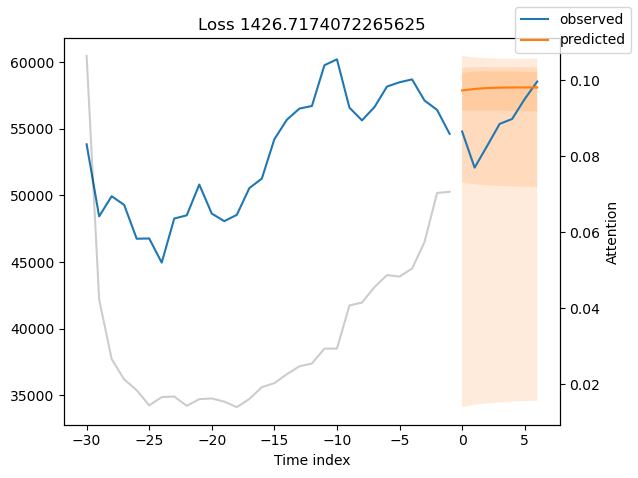

In [23]:
for idx in range(1):  # plot 1 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

In [1]:
# for idx in range(10):  # plot 10 examples
#     best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);